In [2]:
import os
import sys
import csv
import math
import gzip
import numpy

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from collections import defaultdict

%matplotlib inline

In [2]:
pcutoff = 0.05
edge_eps = 1e-9
denoise_eps = 0.05
min_posa = 0.7

In [3]:
# Load Trait Names
trait_names = dict()

reader = csv.reader(gzip.open('../data/loinc.csv.gz'))
reader.next()
for row in reader:
    loinc = row[0]
    name = row[1]
    trait_names[loinc] = name

reader = csv.reader(open('../data/ccs_icd9_map.txt'), delimiter='\t')
reader.next()
for icd9, name, ccscat, ccshindex in reader:
    trait_names[icd9] = name

In [4]:
trait_type = dict()

In [5]:
# Load West Results
west_files = ['../data/west_icd9_done_processed.csv.gz',
              '../data/west_icd9_rq1000_processed.csv.gz',
              '../data/west_lab_done_processed.csv.gz',
              '../data/west_lab_rq1000_processed.csv.gz']

west = defaultdict(lambda: defaultdict(list))

for wf in west_files:
    print wf
    fh = gzip.open(wf)
    reader = csv.reader(fh)
    reader.next()
    for row in reader:
        if len(row) != 5:
            print row
            raise Exception("Formatting is incorrect.")
        
        trait, nfam, h2, h2err, pval = row
        if h2 == 'None' or h2err == 'None' or float(h2) < edge_eps or float(h2) > (1-edge_eps):
            continue
        
        if float(h2err) < denoise_eps*float(h2):
            continue
        
        nfam = int(nfam)
        h2 = float(h2)
        h2err = float(h2err)
        pval = float(pval)
        
        west[trait][nfam].append({'h2': h2, 'error': h2err, 'pvalue': pval})
        if 'lab' in wf:
            trait_type[trait] = 'lab'
        elif 'icd9' in wf:
            trait_type[trait] = 'icd9'
        else:
            trait_type[trait] = 'quant'
            

len(west)

../data/west_icd9_done_processed.csv.gz
../data/west_icd9_rq1000_processed.csv.gz
../data/west_lab_done_processed.csv.gz
../data/west_lab_rq1000_processed.csv.gz


1494

In [6]:
west_posa = defaultdict(lambda: defaultdict(float))

for trait in west.keys():
    for nfam in west[trait].keys():
        if len(west[trait][nfam]) > 30:
            sig = [d['h2'] for d in west[trait][nfam] if d['pvalue'] <= pcutoff]
            west_posa[trait][nfam] = float(len(sig))/float(len(west[trait][nfam]))

len(west_posa)

801

In [7]:
# Save all results that pass Step 1 of QC for analysis and sharing purposes
ofh = open('../results/h2o_columbia_pass1.txt', 'w')
writer = csv.writer(ofh, delimiter='\t')
writer.writerow(['trait_type', 'trait', 'code', 'sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_solar_pvalue', 'h2o_strap_lo', 'h2o_strap_hi'])

for trait in west_posa.keys():
    for nfam in west_posa[trait].keys():
        if west_posa[trait][nfam] > 0.1: # we need some minimum POSA just so that the h2o can be consistently computed
            h2s = [(d['h2'], d['error'], d['pvalue']) for d in west[trait][nfam] if d['pvalue'] <= pcutoff]
            h2o, h2o_err, h2o_pval = sorted(h2s)[int(math.floor(len(h2s)/2.))]
            h2o_strap_lo = numpy.percentile(zip(*h2s)[0], 2.5)
            h2o_strap_hi = numpy.percentile(zip(*h2s)[0], 97.5)
            writer.writerow([trait_type[trait], trait_names.get(trait, ""), trait, nfam, west_posa[trait][nfam], len(h2s), h2o, h2o_err, h2o_pval, h2o_strap_lo, h2o_strap_hi])

ofh.close()

In [8]:
# Step 2 of QC is to see if they pass our minimum POSA score
west_traits = [t for t in west_posa.keys() if max(west_posa[t].values()) >= min_posa]

# Now we save these data, these will be supplemental data files that are released
ofh = open('../results/h2o_columbia_pass1_pass2.txt', 'w')
writer = csv.writer(ofh, delimiter='\t')
writer.writerow(['trait_type', 'trait', 'code', 'sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_solar_pvalue', 'h2o_strap_lo', 'h2o_strap_hi'])

for trait in west_traits:
    nfam = max([nfam for nfam in west[trait].keys() if west_posa[trait][nfam] >= min_posa])
    h2s = [(d['h2'], d['error'], d['pvalue']) for d in west[trait][nfam] if d['pvalue'] <= pcutoff]
    h2o, h2o_err, h2o_pval = sorted(h2s)[int(math.floor(len(h2s)/2.))]
    h2o_strap_lo = numpy.percentile(zip(*h2s)[0], 2.5)
    h2o_strap_hi = numpy.percentile(zip(*h2s)[0], 97.5)
    writer.writerow([trait_type[trait], trait_names.get(trait, ""), trait, nfam, west_posa[trait][nfam], len(h2s), h2o, h2o_err, h2o_pval, h2o_strap_lo, h2o_strap_hi])


ofh.close()

len(west_traits)

216

In [9]:
# Load East Results
east_files = ['../data/east_icd9_done_processed.csv.gz',
              '../data/east_icd9_rq1000_processed.csv.gz',
              '../data/east_lab_done_processed.csv.gz',
              '../data/east_lab_rq1000_processed.csv.gz']

east = defaultdict(lambda: defaultdict(list))

for ef in east_files:
    print ef
    fh = gzip.open(ef)
    reader = csv.reader(fh)
    reader.next()
    for row in reader:
        if len(row) != 5:
            print row
            raise Exception("Formatting is incorrect.")
        
        trait, nfam, h2, h2err, pval = row
        if h2 == 'None' or h2err == 'None' or float(h2) < edge_eps or float(h2) > (1-edge_eps):
            continue
        
        if float(h2err) < denoise_eps*float(h2):
            continue
        
        nfam = int(nfam)
        h2 = float(h2)
        h2err = float(h2err)
        pval = float(pval)
        
        east[trait][nfam].append({'h2': h2, 'error': h2err, 'pvalue': pval})
        if 'lab' in ef:
            trait_type[trait] = 'lab'
        else:
            trait_type[trait] = 'icd9'
len(east)

../data/east_icd9_done_processed.csv.gz
../data/east_icd9_rq1000_processed.csv.gz
../data/east_lab_done_processed.csv.gz
../data/east_lab_rq1000_processed.csv.gz


1145

In [10]:
east_posa = defaultdict(lambda: defaultdict(float))

for trait in east.keys():
    for nfam in east[trait].keys():
        if len(east[trait][nfam]) > 30:
            sig = [d['h2'] for d in east[trait][nfam] if d['pvalue'] <= pcutoff]
            east_posa[trait][nfam] = float(len(sig))/float(len(east[trait][nfam]))

len(east_posa)

719

In [11]:
# Save all results that pass Step 1 of QC for analysis and sharing purposes
ofh = open('../results/h2o_cornell_pass1.txt', 'w')
writer = csv.writer(ofh, delimiter='\t')
writer.writerow(['trait_type', 'trait', 'code', 'sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_solar_pvalue', 'h2o_strap_lo', 'h2o_strap_hi'])

for trait in east_posa.keys():
    for nfam in east_posa[trait].keys():
        if east_posa[trait][nfam] > 0.1: # we need some minimum POSA just so that the h2o can be consistently computed
            h2s = [(d['h2'], d['error'], d['pvalue']) for d in east[trait][nfam] if d['pvalue'] <= pcutoff]
            h2o, h2o_err, h2o_pval = sorted(h2s)[int(math.floor(len(h2s)/2.))]
            h2o_strap_lo = numpy.percentile(zip(*h2s)[0], 2.5)
            h2o_strap_hi = numpy.percentile(zip(*h2s)[0], 97.5)
            writer.writerow([trait_type[trait], trait_names.get(trait, ""), trait, nfam, east_posa[trait][nfam], len(h2s), h2o, h2o_err, h2o_pval, h2o_strap_lo, h2o_strap_hi])

ofh.close()

In [12]:
# Step 2 of QC is to see if they pass our minimum POSA score
east_traits = [t for t in east_posa.keys() if max(east_posa[t].values()) >= min_posa]

# Now we save these data, these will be supplemental data files that are released
ofh = open('../results/h2o_cornell_pass1_pass2.txt', 'w')
writer = csv.writer(ofh, delimiter='\t')
writer.writerow(['trait_type', 'trait', 'code', 'sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_solar_pvalue', 'h2o_strap_lo', 'h2o_strap_hi'])

for trait in east_traits:
    nfam = max([nfam for nfam in east[trait].keys() if east_posa[trait][nfam] >= min_posa])
    h2s = [(d['h2'], d['error'], d['pvalue']) for d in east[trait][nfam] if d['pvalue'] <= pcutoff]
    h2o, h2o_err, h2o_pval = sorted(h2s)[int(math.floor(len(h2s)/2.))]
    h2o_strap_lo = numpy.percentile(zip(*h2s)[0], 2.5)
    h2o_strap_hi = numpy.percentile(zip(*h2s)[0], 97.5)
    writer.writerow([trait_type[trait], trait_names.get(trait, ""), trait, nfam, east_posa[trait][nfam], len(h2s), h2o, h2o_err, h2o_pval, h2o_strap_lo, h2o_strap_hi])

ofh.close()

len(east_traits)

160

(727, (0.30707176315616025, 2.4370219331940458e-17))

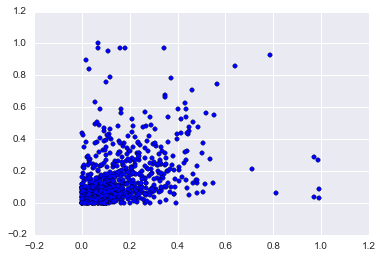

In [13]:
# Pass Step 1 of QC at both sites
common_traits = sorted(set(east) & set(west))

x_west = list()
y_east = list()
for trait in common_traits:
    nfam = max([nfam for nfam in west[trait].keys()])
    h2o = numpy.median([d['h2'] for d in west[trait][nfam]])
    x_west.append(h2o)
    
    nfam = max([nfam for nfam in east[trait].keys()])
    h2o = numpy.median([d['h2'] for d in east[trait][nfam]])
    y_east.append(h2o)

plt.scatter(x_west, y_east)
len(common_traits), stats.pearsonr(x_west, y_east)


(0.69225107664789487, 1.4748164881495593e-06) LinregressResult(slope=0.92879393041618719, intercept=0.055436776750731387, rvalue=0.69225107664789487, pvalue=1.4748164881495614e-06, stderr=0.16137458895800458) 38
(0.63598195278240843, 1.5561325081290001e-06) LinregressResult(slope=0.71628891603869216, intercept=0.093757104979967615, rvalue=0.63598195278240854, pvalue=1.5561325081289915e-06, stderr=0.12956505809901508) 47


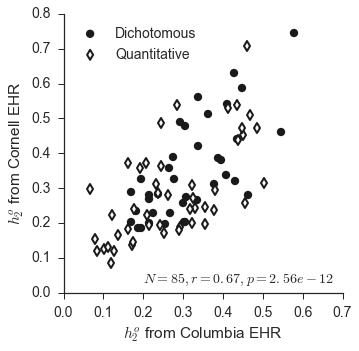

In [14]:
# Pass Step 1 and Step 2 of QC at Both Sites
common_traits = sorted(set(east_traits) & set(west_traits))

x_west = list()
y_east = list()

for trait in common_traits:
    nfam = max([nfam for nfam in west[trait].keys() if west_posa[trait][nfam] >= min_posa])
    h2s = [d['h2'] for d in west[trait][nfam] if d['pvalue'] <= pcutoff]
    h2o = sorted(h2s)[int(math.floor(len(h2s)/2.))]
    #h2o = numpy.median([d['h2'] for d in west[trait][nfam]])
    x_west.append(h2o)
    
    nfam = max([nfam for nfam in east[trait].keys() if east_posa[trait][nfam] >= min_posa])
    h2s = [d['h2'] for d in east[trait][nfam] if d['pvalue'] <= pcutoff]
    h2o = sorted(h2s)[int(math.floor(len(h2s)/2.))]
    #h2o = numpy.median([d['h2'] for d in east[trait][nfam]])
    y_east.append(h2o)

r, p = stats.pearsonr(x_west, y_east)
N = len(common_traits)

sns.set(style="ticks", color_codes=True, font_scale=1.4)

fig = plt.figure(figsize=(5,5))
x = [x for x, t in zip(x_west, common_traits) if trait_type[t] == 'icd9']
y = [y for y, t in zip(y_east, common_traits) if trait_type[t] == 'icd9']
print stats.pearsonr(x,y), stats.linregress(x,y), len(x)
ndiag = len(x)
p1 = plt.scatter(x, y, color='k', s=40, c='k', marker='o', lw=2)

x = [x for x, t in zip(x_west, common_traits) if trait_type[t] == 'lab']
y = [y for y, t in zip(y_east, common_traits) if trait_type[t] == 'lab']
print stats.pearsonr(x,y), stats.linregress(x,y), len(x)
nlab = len(x)
p2 = plt.scatter(x, y, color='k', s=50, c='white', marker='d', lw=2)

plt.ylabel(u'$h_2^o$ from Cornell EHR')
plt.xlabel(u'$h_2^o$ from Columbia EHR')
plt.text(0.2, 0.03, u'$N=%d, r=%.2f, p=%.2e$' % (N, r, p), fontsize=14)

plt.legend(['Dichotomous', 'Quantitative'], loc='upper left')

sns.despine(trim=True)

plt.savefig('../results/h2o_corelation_between_sites.pdf')

In [15]:
# HDL versus LDL
traits = ['2089-1', '2085-9']

trait = traits[0]
nfam = max([nfam for nfam in west[trait].keys() if west_posa[trait][nfam] >= min_posa])
h2s_t1 = [d['h2'] for d in west[trait][nfam] if d['pvalue'] <= pcutoff]

trait = traits[1]
nfam = max([nfam for nfam in west[trait].keys() if west_posa[trait][nfam] >= min_posa])
h2s_t2 = [d['h2'] for d in west[trait][nfam] if d['pvalue'] <= pcutoff]

print numpy.median(h2s_t1), numpy.median(h2s_t2)
print "west %s vs %s: %s" % (traits[0], traits[1], stats.ttest_ind(h2s_t2, h2s_t1))

trait = traits[0]
nfam = max([nfam for nfam in east[trait].keys() if east_posa[trait][nfam] >= min_posa])
h2s_t1 = [d['h2'] for d in east[trait][nfam] if d['pvalue'] <= pcutoff]

trait = traits[1]
nfam = max([nfam for nfam in east[trait].keys() if east_posa[trait][nfam] >= min_posa])
h2s_t2 = [d['h2'] for d in east[trait][nfam] if d['pvalue'] <= pcutoff]

print numpy.median(h2s_t1), numpy.median(h2s_t2)
print "east %s vs %s: %s" % (traits[0], traits[1], stats.ttest_ind(h2s_t2, h2s_t1))


0.3557882 0.4864183
west 2089-1 vs 2085-9: Ttest_indResult(statistic=18.873470175338849, pvalue=5.3171248971954858e-41)
0.24588215 0.4732172
east 2089-1 vs 2085-9: Ttest_indResult(statistic=45.229513531243455, pvalue=6.2374126331123445e-159)


In [16]:
# Obesity vs. Morbid Obesity
traits = ['278.00', '278.01']

trait = traits[0]
nfam = max([nfam for nfam in west[trait].keys() if west_posa[trait][nfam] >= min_posa])
h2s_t1 = [d['h2'] for d in west[trait][nfam] if d['pvalue'] <= pcutoff]

trait = traits[1]
nfam = max([nfam for nfam in west[trait].keys() if west_posa[trait][nfam] >= min_posa])
h2s_t2 = [d['h2'] for d in west[trait][nfam] if d['pvalue'] <= pcutoff]

print numpy.median(h2s_t1), numpy.median(h2s_t2)
print "west %s vs %s: %s" % (traits[0], traits[1], stats.ttest_ind(h2s_t2, h2s_t1))

trait = traits[0]
nfam = max([nfam for nfam in east[trait].keys() if east_posa[trait][nfam] >= min_posa])
h2s_t1 = [d['h2'] for d in east[trait][nfam] if d['pvalue'] <= pcutoff]

trait = traits[1]
nfam = max([nfam for nfam in east[trait].keys() if east_posa[trait][nfam] >= min_posa])
h2s_t2 = [d['h2'] for d in east[trait][nfam] if d['pvalue'] <= pcutoff]

print numpy.median(h2s_t1), numpy.median(h2s_t2)
print "east %s vs %s: %s" % (traits[0], traits[1], stats.ttest_ind(h2s_t2, h2s_t1))



0.4282796 0.36118295
west 278.00 vs 278.01: Ttest_indResult(statistic=-5.8795860215098887, pvalue=2.1424890662735081e-08)
0.62754725 0.5125533
east 278.00 vs 278.01: Ttest_indResult(statistic=-6.3119080368417659, pvalue=3.0740385724542014e-09)
